In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,4)
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = 16

In [2]:
import pandas as pd
import numpy as np

import plotly.io as pio
pio.renderers.default = 'notebook'

## Table of Contents

# Load Data
- Load data from DeFiLlama
- [Optional] Interpolate data to hourly

# Slippage Models

# Choose a Strategy
- Set up Strategy triggers
- Choose from pre-coded strategies:
    - Brute Force Optimization

# Run Backtest
- Run single strategy runs

# Analyze Backtests
- Analyze results with pre-built plotting
- Write your own analysis

In [ ]:
# Token used in this notebook
token = "USDT"

# Loading Data

## Load Data From DefiLlama

In [114]:
pool_urls = {}
pool_urls[token] = """
# token defined above
https://defillama.com/yields/pool/f981a304-bb6c-45b8-b0c5-fd2f515ad23a
https://defillama.com/yields/pool/4e8cc592-c8d5-4824-8155-128ba521e903
https://defillama.com/yields/pool/60d657c9-5f63-4771-a85b-2cf8d507ec00
https://defillama.com/yields/pool/c037a916-a462-4c65-b217-100db0fdc0e0
https://defillama.com/yields/pool/57647093-2868-4e65-97ab-9cae8ec74e7d
"""
def url_raw_to_pool_id(url_raw):
  return [url.split("/")[-1] for url in  url_raw.split("\n")[1:-1] if "#" not in url]

pool_ids = {t:url_raw_to_pool_id(pool_ids) for t, pool_ids in pool_urls.items()}

In [115]:
from dope.backengine.maestro import BackEngineMaestro
maestro = BackEngineMaestro()

In [116]:
data, borrow_lend_data = maestro.load_defilama_with_token_pool_id(pool_ids)

USDT
Ethereum:aave-v3:USDT f981a304-bb6c-45b8-b0c5-fd2f515ad23a 469 469
Ethereum:fluid:USDT 4e8cc592-c8d5-4824-8155-128ba521e903 105 105
Ethereum:compound-v2:USDT 57647093-2868-4e65-97ab-9cae8ec74e7d 469 469
Ethereum:morpho-blue(LTV: 86%):WBTC-USDT c037a916-a462-4c65-b217-100db0fdc0e0 207 207
Ethereum:aave-v2:USDT 60d657c9-5f63-4771-a85b-2cf8d507ec00 467 467


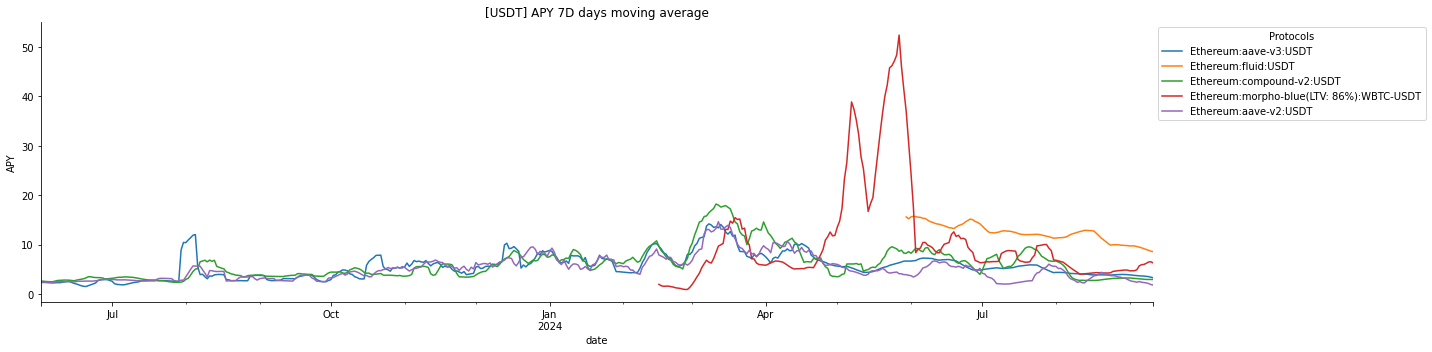

In [117]:
maestro.set_data(borrow_lend_data)
maestro.plot_rates_ts(agg_str="7D")

## [Optional] Interpolate data to hourly

In [123]:

enhanced_borrow_lend_data = {t:{} for t in borrow_lend_data.keys()}
for token in enhanced_borrow_lend_data.keys():
  for mkt in borrow_lend_data[token].keys():
    enhanced_borrow_lend_data[token][mkt] = (
      borrow_lend_data[token][mkt]
      .resample("1h")
      .last()
      .infer_objects(copy=False) 
      .apply(pd.to_numeric, errors='coerce')
      .interpolate()
    )

from dope.backengine.maestro import BacktestData

enhanced_borrow_lend_data = BacktestData(enhanced_borrow_lend_data)

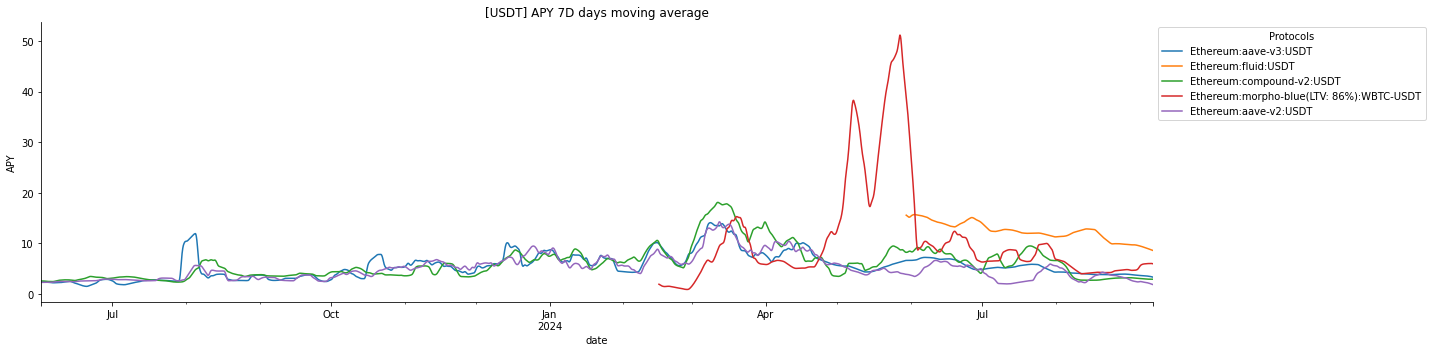

In [124]:
maestro.set_data(enhanced_borrow_lend_data)
maestro.plot_rates_ts(agg_str="7D")

# Slippage Models

In [118]:
from dope.market_impact.neighborhood import NeighborhoodMktImpactModel

In [119]:
mkt_model = NeighborhoodMktImpactModel()

2023-09-09 00:00:00


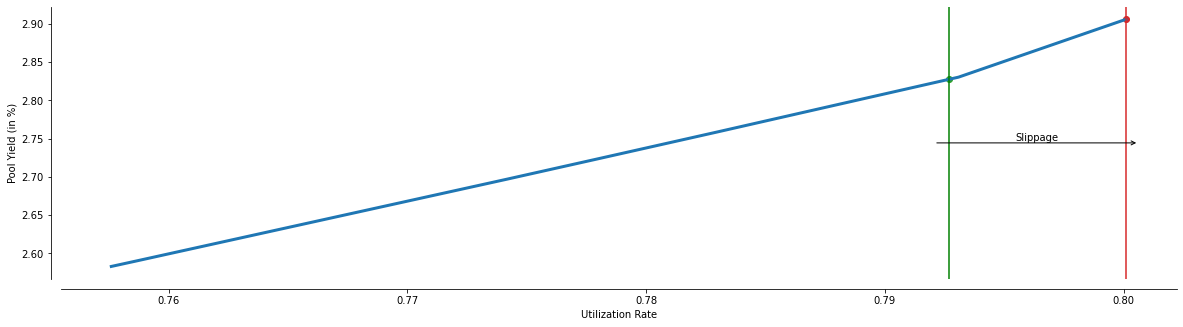

In [120]:
mkt = "Ethereum:aave-v3:USDT"
mkt_model.set_data_ref(borrow_lend_data[token][mkt])
date_now = borrow_lend_data[token][mkt].index[100]
print(date_now)
_ = mkt_model.impact(date_now,  2_000_000, is_borrow=False, should_plot=True)

2024-03-14 00:00:00


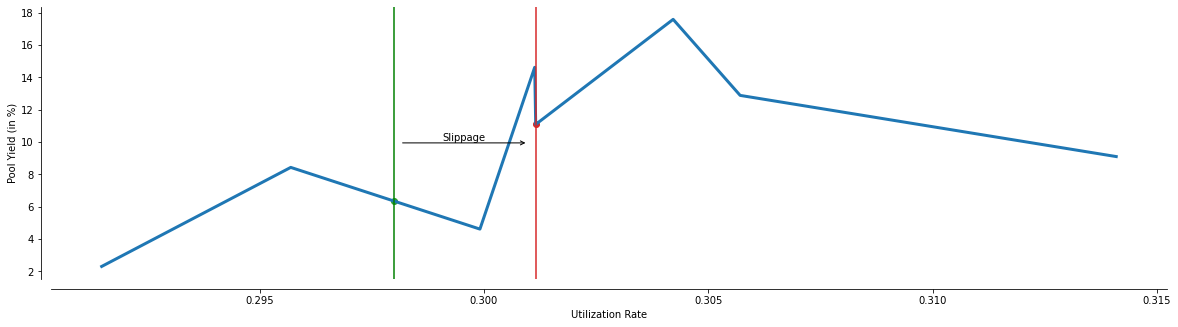

In [121]:
mkt = "Ethereum:morpho-blue(LTV: 86%):WBTC-USDT"
mkt_model.set_data_ref(borrow_lend_data[token][mkt])
date_now = borrow_lend_data[token][mkt].index[27]
print(date_now)
_ = mkt_model.impact(date_now, 300_000, is_borrow=False, should_plot=True)

# Backtest

In [122]:
# import agents
from dope.backengine.agents.jackreaper import LenderJackReaper
from dope.backengine.agents.quadratic import LenderQuadratic

In [16]:
from dope.backengine.arbengine import ArbBacktester
from dope.backengine.runsummary import BacktestSummary

In [132]:
summaries = {}

ws = {}
CAPITAL = 1_000_000

In [133]:
# Setup data

run_data = borrow_lend_data
#run_data = enhanced_borrow_lend_data

# Get mkt impact model
mkt_impact = maestro.get_historical_mkt_impact_model(run_data)

# Daily triggers for benchmark
triggers = run_data.to_block(token).utilizationRate.resample("7D").last().index[1:]
# Setup strategy
strategy = LenderJackReaper(
  token=token,
  capital=CAPITAL,
  days_window=7,
  triggers=triggers
)
strategy.verbose = False

# setup backtest
arbt = ArbBacktester(
  strategy=strategy,
  borrow_lend_data=run_data,
  data=run_data,
  mkt_impact=mkt_impact
)

# Run Backtest
summaries["jackreaper"], _ = arbt()

Running Backtest for 469 | token:USDT


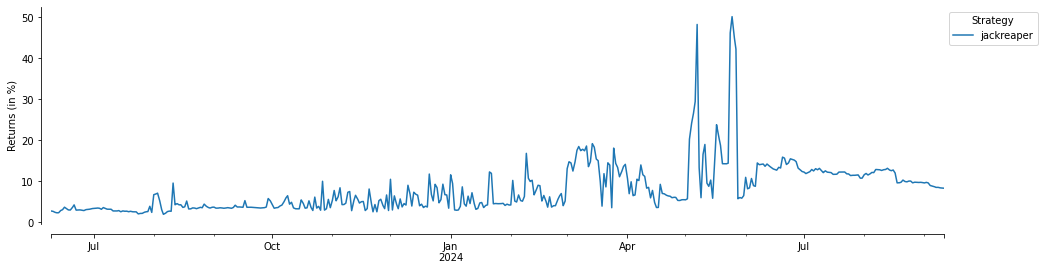

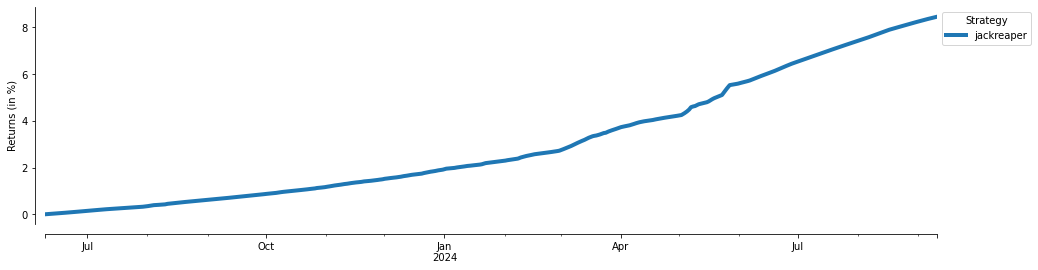

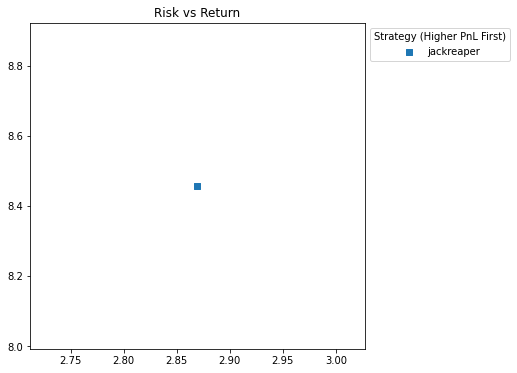

jackreaper    8.457331
dtype: float64


In [134]:
summary = pd.concat(summaries).unstack(level=0)
from dope.backengine.runsummary import BacktestSummary
from dope.backengine.plotting.fofarticle import Plotter
plot = Plotter(summary)
plot.summary_view()

# Analysis

## Load Backtests from Disk

In [79]:
_summaries = {}

bts = {
  "mainchain-lend": "main-chain-daily-triggers-hourly-data",
  "mainPlus-arb": "optimization+stable-arb-many-protocols",
  "mainPlus-lend":"2024-06-03-main-chain-daily-triggers-daily-data-many-protocols",
}

for _run_tag, _run_name in bts.items():
  _run = BacktestSummary.load(_run_name)
  _summaries.update({f"{_run_tag}-{k}":_run.summary[k] for k in _run.summary.keys()})

summary = pd.concat(_summaries).unstack(level=0)

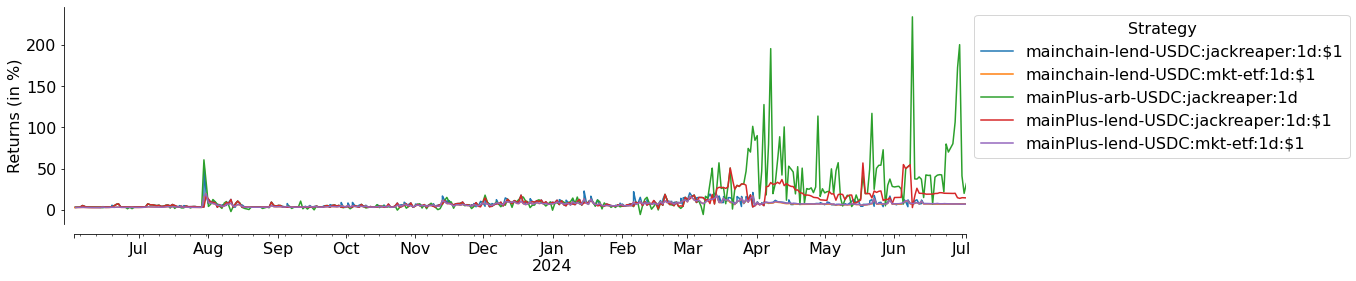

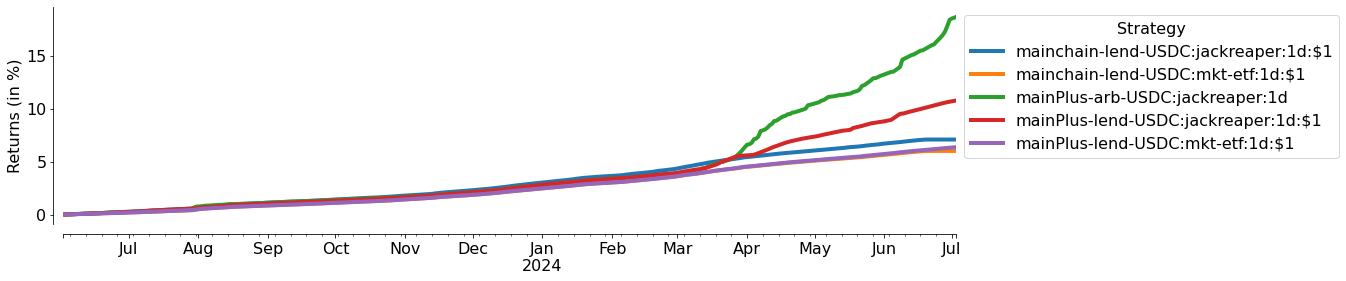

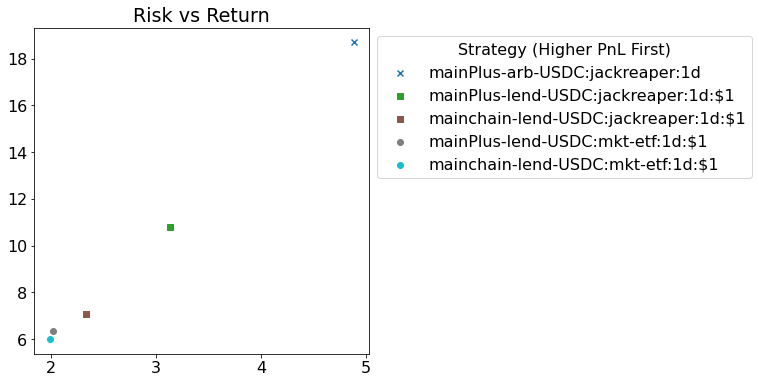

mainchain-lend-USDC:jackreaper:1d:$1     7.089111
mainchain-lend-USDC:mkt-etf:1d:$1        6.010555
mainPlus-arb-USDC:jackreaper:1d         18.688585
mainPlus-lend-USDC:jackreaper:1d:$1     10.782025
mainPlus-lend-USDC:mkt-etf:1d:$1         6.368559
dtype: float64


In [80]:
plot = Plotter(summary)
plot.summary_view()